# Meniscus between plates. Solution


Find the shape for two parallels walls separated a distance $L$

Hint: In the middle point between both walls, curvature is not zero, so there is also there a pressure jump. This pressure jump is related, then, to the height of the column, $H$. I suggest to change corrdinate axes, as shown in the picture, and change the first equation as

$$ \frac{\rho g (z+H)}{\gamma} - \frac{z''}{\left(1 + {z'}^2\right)^{3/2}} = 0 $$

Also, there are 2 boundary conditions: the derivative of $z(x)$ for $x=-\frac{L}{2}$ and for $x=\frac{L}{2}$

![image.png](MeniscusBetweenPlates.png)

***

The exact solution of this problems can be found, both for planar and axisymmetric (capillary tube) can be found in [this paper by Liu et al.(2018)](https://link.springer.com/article/10.1140/epje/i2018-11648-1). We are going to find the shape with numerical integration, in a similar way as we have done with the shape with only one 
plate.

We ca consider two method. In the first, we perform one integration of the second order ODE and the second is numerically integrated. In the second method, that is left as exercise, the second order ODE is written as a system of two first order ODE's and both are numerically integrated

## Method 1

In this method the origin of $x$ is at the wall and the numerical integration is done until the middle point between plates. All the variables are normalized with capillary length 
$ l_s = \frac{\rho g}{\gamma} $. Hence,

\begin{eqnarray}
\xi &=& \frac{x}{l_s} \\
\eta &=& \frac{z}{l_s} \\
\beta &=& \frac{H}{l_s} \\
\lambda &=& \frac{L}{l_s} 
\end{eqnarray}

In [1]:
import numpy as np
import sympy as sp
sp.init_printing()

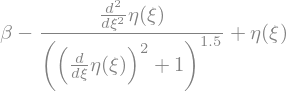

In [2]:
xi,theta, beta = sp.symbols('xi,theta,beta',positive=True)
eta = sp.Function('eta')
exp = (eta(xi)+beta)-eta(xi).diff(xi,2)/(1+eta(xi).diff(xi)**2)**(3/2)
display(exp)

As in the case of one plate, this equation can be integrated with an integration factor $\eta'$.

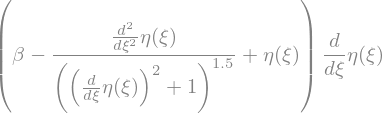

In [3]:
exp = exp*eta(xi).diff(xi)
display(exp)

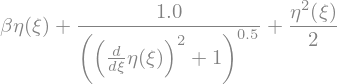

In [4]:
exp2 = exp.integrate(xi)
display(exp2)

Again, when $\eta=0$, the first derivative is $0$ too, so, this is again 1. And $delta$, the normalized height of water in the wall (above center of meniscus) can be calculated by imposing its derivative.

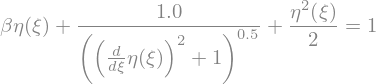

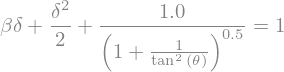

In [5]:
dEq = sp.Eq(exp2,1)
display(dEq)
delta = sp.symbols('delta')
deltaEq = dEq.replace(eta(xi).diff(xi),-1/sp.tan(theta)).replace(eta(xi),delta)
display(deltaEq)

We keep the second solution, which is the positive one

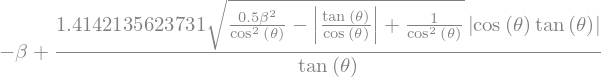

In [6]:
deltaSol=sp.solve(deltaEq,delta)[1]
deltaSol.simplify().trigsimp()
display(deltaSol)

This is function of the contact angle ($\theta$) but also of the height of the column, $\beta$. The higher is $\beta$, the lower is $\delta$. This is because also $\lambda$ will be lower, and the meniscus is narrower.

We construct a function to calculate the numerical value of $\delta$ (initial value of $\eta$) with $\beta$ and $\theta$.

In [7]:
eta0_n = sp.lambdify((beta,theta),deltaSol)

and also, we construct the first order that we want to integrate, by defining the first derivative of $\eta$.

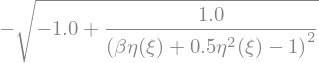

In [8]:
f = sp.solve(dEq,eta(xi).diff(xi))[0]
display(f)

and its numerical version

In [9]:
f_np = sp.lambdify((eta(xi),xi,beta),f)

and now we can integrate it, choosing input values for contact angle $\theta$ and for $\beta$ (height of column).

In [10]:
from scipy.integrate import odeint
theta_n = np.deg2rad(30)
beta_n = 0.01
eta0 = sp.N(eta0_n(beta_n,theta_n),4)
display(eta0)

An estimation of distance between plates can be done easily with the circular approximation, yielding $\lambda = \frac{2\cos{\theta}}{\beta}$. So, the distance to the middle point will be around $\frac{\cos{\theta}}{\beta}$. We use a slightly larger value for the limit of numerical integration

In [11]:
l_2_est = np.cos(theta_n)/beta_n
xi_p = np.linspace(0,1.1*l_2_est,1000) # long enough for our case
eta_np = odeint(f_np,eta0,xi_p,args=(beta_n,))[:,0] #odeint returns an 2-D array (one for each equation of the system) with only one row. We only need the 1-D array.

 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5148195504208D+01   r2 =                  NaN


<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in sqrt
  return (-sqrt(-1.0 + 1.0/(0.5*_Dummy_2007**2 + _Dummy_2007*beta - 1)**2))
/home/robert/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


It gives a warning because beyond the middle point of meniscus the derivative gives imaginary values (negative argument in the root square of `f`. A trick is to detect this `NaN` 
and drop them from `eta_np` and `xi_p`. Then, the last value of `xi_p` is the numerical result for $\lambda/2$. 

In [12]:
xi_p = xi_p[~np.isnan(eta_np)]
eta_np = eta_np[~np.isnan(eta_np)]
l_2 = xi_p[-1]
print('numerical value for lambda: {:.3g}'.format(l_2*2))
print('estimated value for lambda: {:.3g}'.format(l_2_est*2))

numerical value for lambda: 191
estimated value for lambda: 173


In [13]:
R = l_2/np.cos(theta_n)
eta_circ = R - np.sqrt(R**2 - (l_2-xi_p)**2)

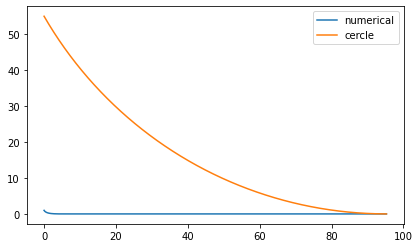

In [14]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,4))
plt.gca().set_aspect('equal', adjustable='box')
ax.plot(xi_p,eta_np,scaley=True, label='numerical')
ax.plot(xi_p,eta_circ,scaley=True, label ='cercle')
ax.legend()

## Method 2

In this method, we write the second order ODE as a system of two first order ODE's:

\begin{eqnarray}
\zeta'(\zeta,\eta,\xi) &=& (\eta(\xi) + \beta)\left(1+\zeta(\xi)^2\right)^\frac{3}{2} \\
\eta'(\zeta,\eta,\xi) &=& \zeta(\xi)
\end{eqnarray}

and, if the coordinates are centered in the middle point (as indicated in the figure), the initial conditions are $\eta(\xi=0)=\zeta(\xi=0)=0$.

_Question:_ How do we calculate the value of $\lambda$?